In [1]:
import tensorflow as tf
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sb

# Data preview

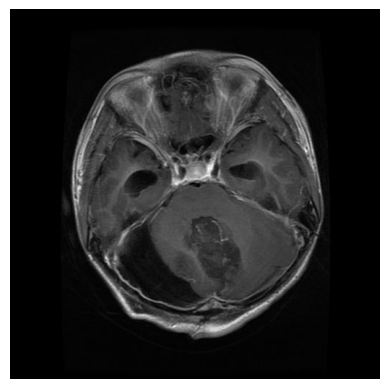

In [2]:
img = cv.imread('data\\Testing\\glioma\\Te-glTr_0000.jpg')
plt.axis('off')
plt.imshow(img)

If we have 256x256px image and each pixel has 3 channels it basically has **196 608** values in it,
<br>
by using *color_mode = 'grayscale'* we reduce it to one value and we end up with 3 times less values to compute which is **65 536**.

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data\\Training', batch_size=8, color_mode='grayscale')
data_test = tf.keras.utils.image_dataset_from_directory('data\\Testing')

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [4]:
class_names = data.class_names

In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

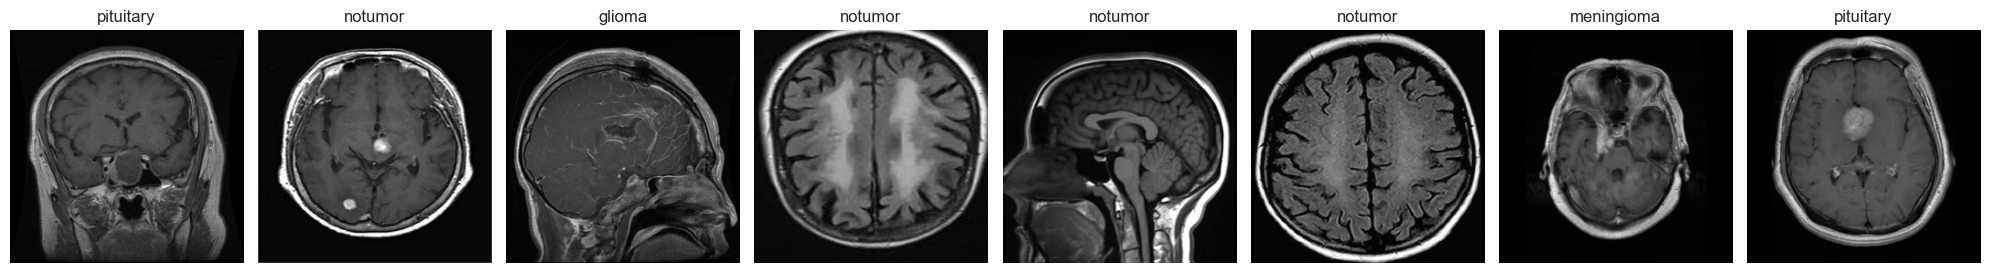

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20,10))
for i, img in enumerate(batch[0][:8]):
    class_name = class_names[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

# Feature scaling
We scale our values from range (0, 255) to (0, 1)
<br><br>
x = image values
<br> 
y = labels

In [7]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
255.0


In [8]:
data = data.map(lambda x, y: (x/255, y))

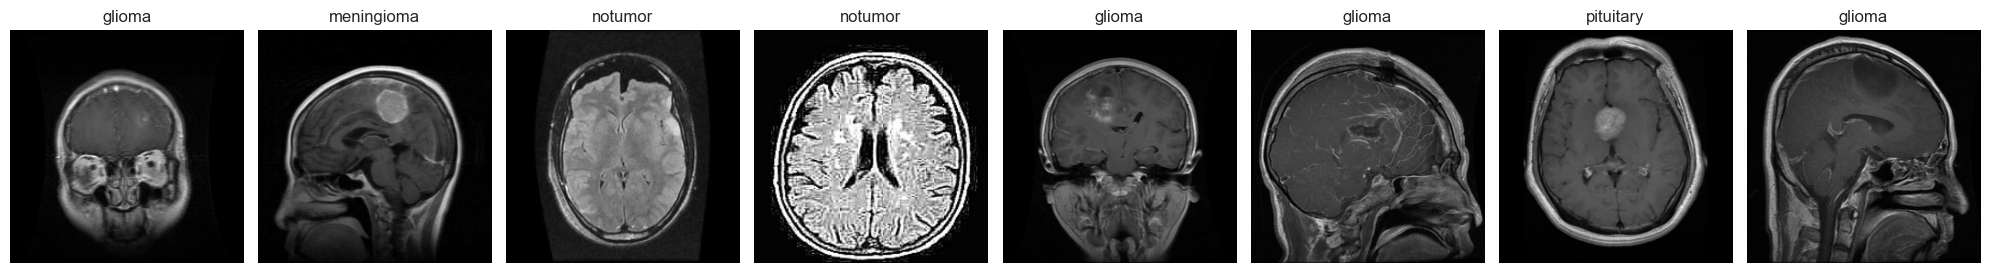

In [9]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 10))
for i, img in enumerate(batch[0][:8]):
    class_name = class_names[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

In [10]:
min_value = data_iterator.next()[0].min()
max_value = data_iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.9963226


In [11]:
train_batch_size = round(len(data) * 0.8)
val_batch_size = round(len(data) * 0.2)

len(data) == train_batch_size + val_batch_size

True

In [12]:
train = data.take(train_batch_size)
val = data.skip(train_batch_size).take(val_batch_size)
test = data_test.take(len(data_test))
print(
    f"train: {len(train)}\nval: {len(val)}\ntest: {len(test)}"
)

train: 571
val: 143
test: 41


# Creating CNN Model
As input shape we apply values that corresponds to: width = 256, height = 256 and channel = 1 (we use grayscaled images instead of RGB ones).
<br>
__*ReLU*__ activation function cleans our output from all unecesary negative values, replacing them with zeros that came from filter multiplication.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

In [14]:
model = Sequential()

In [15]:
model.add(Input(shape=(256, 256, 1)))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [16]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,108 (14.10 MB)

 Trainable params: 3,697,108 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - accuracy: 0.6272 - loss: 0.8552 - val_accuracy: 0.8610 - val_loss: 0.3962
Epoch 2/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.8852 - loss: 0.3064 - val_accuracy: 0.8960 - val_loss: 0.2997
Epoch 3/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9472 - loss: 0.1528 - val_accuracy: 0.9073 - val_loss: 0.3081
Epoch 4/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9711 - loss: 0.0836 - val_accuracy: 0.9143 - val_loss: 0.3895
Epoch 5/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9768 - loss: 0.0696 - val_accuracy: 0.9056 - val_loss: 0.3353
Epoch 6/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.9884 - loss: 0.0362 - val_accuracy: 0.9082 - val_loss: 0.3276
Epoch 7/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.9885 - loss: 0.0378 - val_accuracy: 0.9371 - val_loss: 0.2746
Epoch 8/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9934 - loss: 0.0238 - 

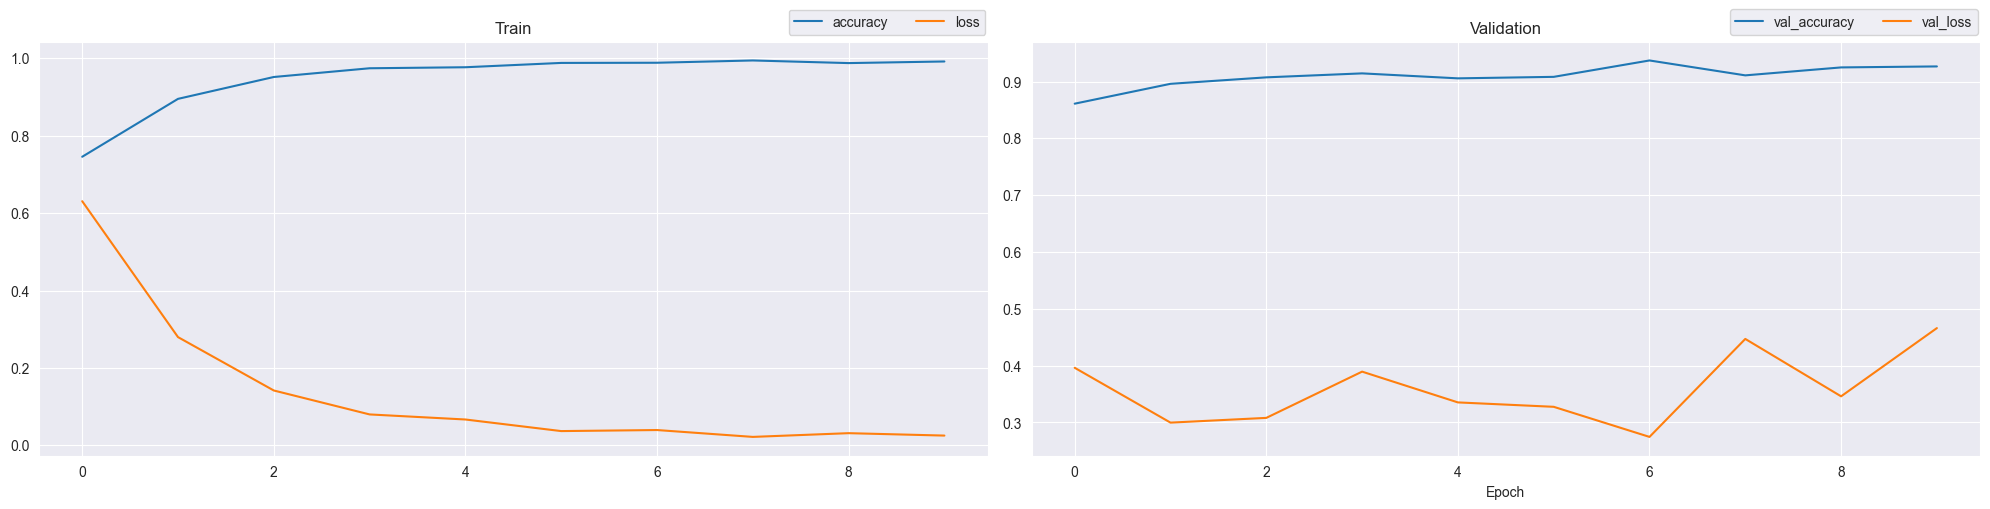

In [119]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i in range(4):
    fig = sb.lineplot(y=hist.history[acc_labels[i]], x=[x for x in range(10)], label=acc_labels[i], ax=axes[i//2])
    axes[i//2].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)

axes[0].set_title('Train')
axes[1].set_title('Validation')

plt.tight_layout()
plt.xlabel('Epoch')
plt.show()